# Clusterização de Jogadores com Base em Perfil e Desempenho Físico

### Integrantes
Matheus Grandinetti Barbosa Lima

Pedro Henrique Baptista Fernandes

Marcelo Augusto Mrad Marteleto

Pedro Henrique Egito

# 0. Instalação de dependências



In [2]:

!pip install pandas pyarrow matplotlib openpyxl tqdm scikit-learn bs4

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


## 1. Imports e leitura do arquivo

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import json
from sklearn.decomposition import PCA
import ast
import seaborn as sns

In [3]:
plt.rcParams["figure.figsize"] = (10, 5)

FILE = Path("Injuries.xlsx")
df = pd.read_excel(FILE)

print(f"Linhas: {len(df):,}")
df.head()

Linhas: 107,971


Season           Injury          from         until      Days Games missed  \
0  23/24  Adductor injury  Jul 10, 2023   Oct 8, 2023   90 days           11   
1  20/21   unknown injury   Apr 7, 2021  Apr 29, 2021   22 days            4   
2  18/19   unknown injury  Apr 26, 2019  May 18, 2019   22 days            2   
3  18/19    Muscle injury  Apr 11, 2019  Apr 18, 2019    7 days            1   
4  20/21    Ankle surgery  Dec 16, 2020  Jun 30, 2021  196 days           24   

      player_name  player_id  \
0  Ricardo Mangas     314944   
1  Ricardo Mangas     314944   
2    Lassana Faye     315129   
3    Lassana Faye     315129   
4    Mink Peeters     315149   

                                        url_injuries  
0  https://www.transfermarkt.co.uk/ricardo-mangas...  
1  https://www.transfermarkt.co.uk/ricardo-mangas...  
2  https://www.transfermarkt.co.uk/lassana-faye/v...  
3  https://www.transfermarkt.co.uk/lassana-faye/v...  
4  https://www.transfermarkt.co.uk/mink-peeters/v...

#  2. Limpeza rápida e colunas auxiliares

In [4]:
df["days_num"] = (
    df["Days"]
    .astype(str)
    .str.extract(r"(\d+)")
    .astype(float)
)

def season_to_year(s):
    if isinstance(s, str) and "/" in s:
        yy = int(s.split("/")[0])
        return 1900 + yy if yy >= 50 else 2000 + yy
    return pd.NA

df["season_year"] = df["Season"].apply(season_to_year)

df[["Season", "season_year", "days_num"]].head()

Season  season_year  days_num
0  23/24         2023      90.0
1  20/21         2020      22.0
2  18/19         2018      22.0
3  18/19         2018       7.0
4  20/21         2020     196.0

# 3. Top-10 tipos de lesão mais frequentes

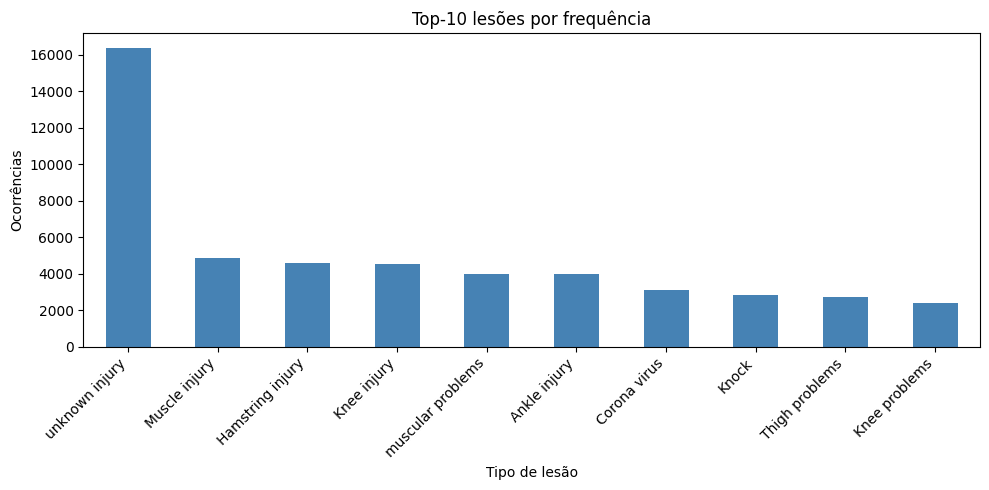

In [5]:
top10 = df["Injury"].value_counts().head(10)
top10.plot(kind="bar", color="steelblue")
plt.title("Top-10 lesões por frequência")
plt.xlabel("Tipo de lesão")
plt.ylabel("Ocorrências")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 4. Lesões com maior média de dias afastado  
### (considerando apenas tipos com ≥ 20 ocorrências)

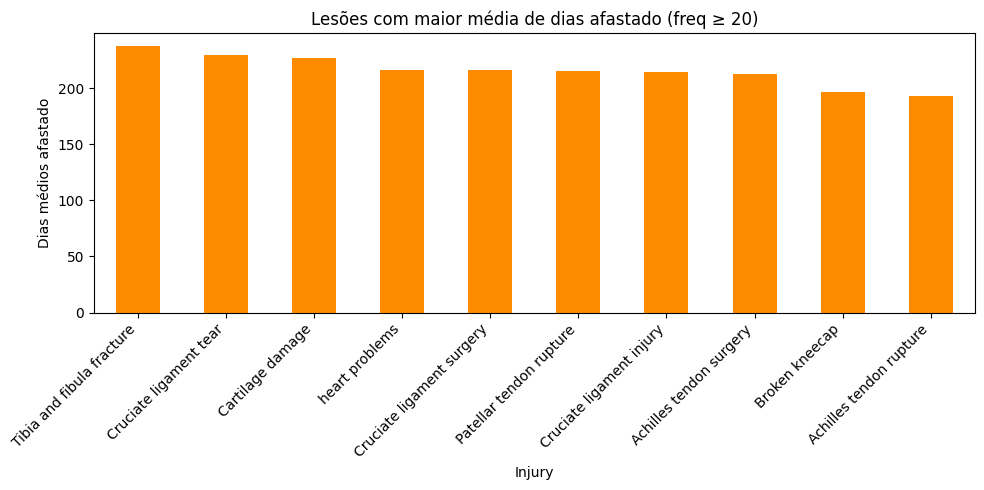

In [6]:
severe = (
    df.groupby("Injury")
    .agg(freq=("Injury", "size"), mean_days=("days_num", "mean"))
    .query("freq >= 20")
    .sort_values("mean_days", ascending=False)
    .head(10)
)

severe["mean_days"].plot(kind="bar", color="darkorange")
plt.title("Lesões com maior média de dias afastado (freq ≥ 20)")
plt.ylabel("Dias médios afastado")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

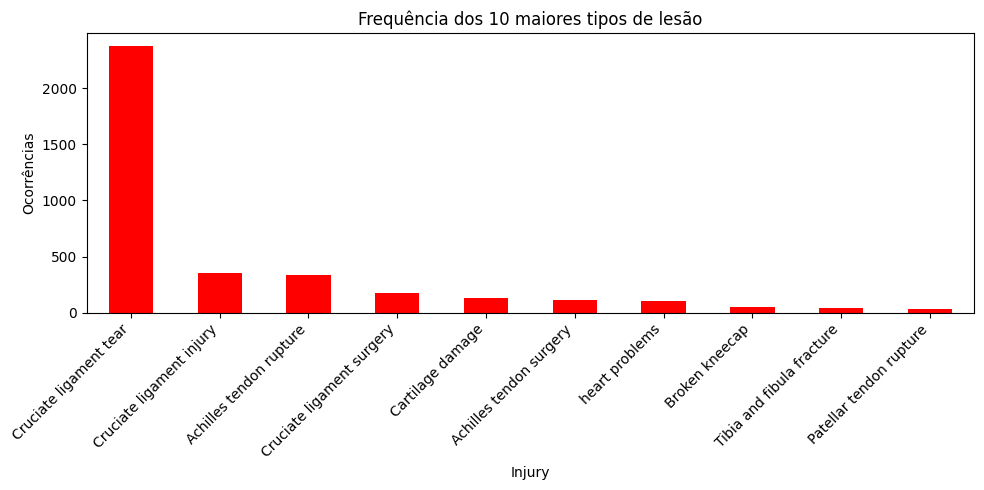

In [7]:
severe.sort_values(by=["freq"], ascending=False)["freq"].plot(kind="bar", color="red")
plt.title("Frequência dos 10 maiores tipos de lesão")
plt.ylabel("Ocorrências")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

É interessante perceber que mesmo possuindo maior média de dias afastados, fraturas de tíbia e fíbula possuem números de ocorrência bem menores que outros tipos de lesão, com destaque para ruptura do ligamento cruzado, que possui frequência e dias de afastamento altos.

# 5. Evolução de registros por temporada (2000-2023)

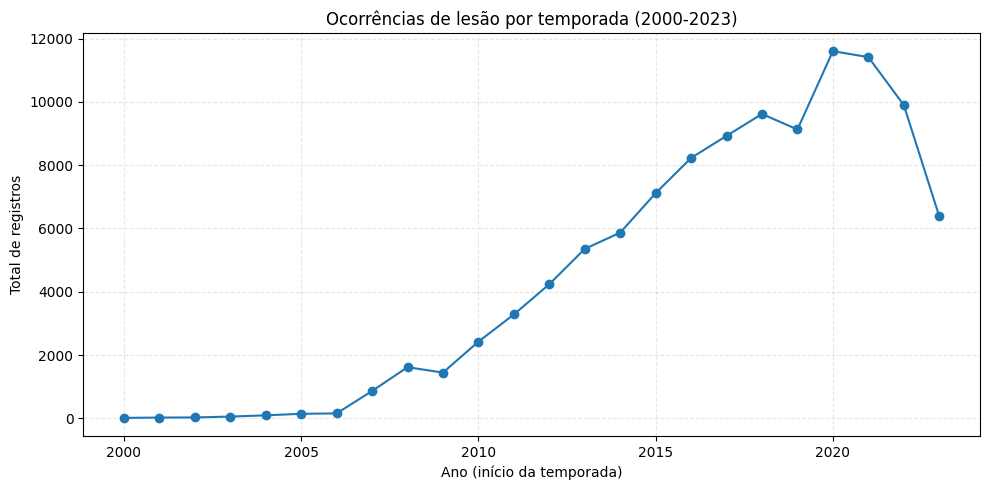

In [8]:
trend = (
    df[df["season_year"].between(2000, 2023)]
    .groupby("season_year")["Injury"]
    .count()
)

trend.plot(marker="o")
plt.title("Ocorrências de lesão por temporada (2000-2023)")
plt.xlabel("Ano (início da temporada)")
plt.ylabel("Total de registros")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

O comportamento ascendente do total de registros pode significar várias coisas: um aumento de competitividade e esforço nas temporadas, o que implica em maior frequência de lesões. Melhora na coleta de dados, com técnicas mais refinadas e democratizadas.

# 6. Distribuição de dias afastado

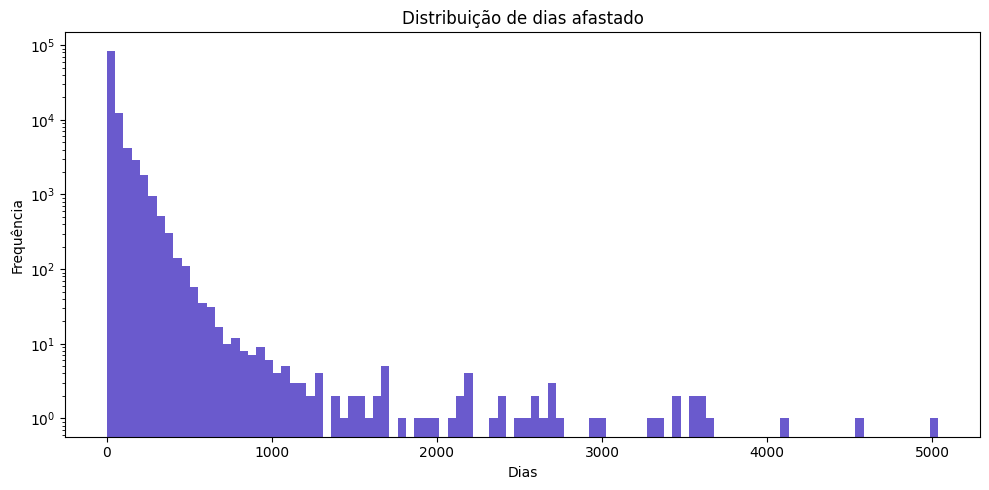

In [9]:
df["days_num"] = pd.to_numeric(df["days_num"], errors="coerce")
df["days_num"].dropna().plot(kind="hist", bins=100, color="slateblue")
plt.yscale("log")
plt.title("Distribuição de dias afastado")
plt.xlabel("Dias")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

A frequência de lesões com menos dias de afastamento é muito mais expressiva que a de longos períodos, o que faz sentido, já que grande parte das lesões envolvem traumas pequenos e pontuais.

# Observações iniciais
- Unknown/Muscle/Hamstring/Knee dominam em frequência.
- Fraturas e rupturas ligamentares lideram em média de dias fora (> 200).
- Crescente número de registros após 2010, pico em 2020-21 (prováveis efeitos de Covid/relato).
- Distribuição de dias é assimétrica – longa cauda de casos severos.
- Esses achados alimentam nossas futuras etapas:
- Selecionar rótulos de severidade (> 90 dias) para modelos de risco.
- Combinar com métricas físicas para detectar clusters de alto risco.

# 7. Enriquecendo com scraping dinâmico (Transfermarkt)
 - Pegaremos lesões **atuais** na La Liga
- Baixaremos histórico recente (últimas 3 temporadas) para cada jogador
- Geraremos novas métricas de risco
 - Uniremos ao `df` original

In [12]:
from scraper.transfermarkt_scraper import (
    get_league_injuries,
    get_team_player_urls,
    get_player_injury_history,
    get_multiple_players_injury_history,
)
from tqdm import tqdm
import requests, time

sess = requests.Session()

In [13]:
# ### 7.1 Jogadores da temporada 23/24 no Injuries.xlsx

# %%
# 'Season' e 'player_name' vêm do Injuries.xlsx
players_23 = (
    df[df["Season"] == "23/24"]["player_name"]
    .drop_duplicates()
    .reset_index(drop=True)
)
print(f"Jogadores únicos em 23/24 no Injuries.xlsx: {len(players_23)}")

Jogadores únicos em 23/24 no Injuries.xlsx: 4103


In [14]:
# ------------------------------------------------------------------
# 7.2 Scraping liga → tabela de lesionados hoje
# ------------------------------------------------------------------
today_laliga = get_league_injuries(country_name="Spain", session=sess)
today_laliga.head()

HTTPError: 502 Server Error: Bad Gateway for url: https://www.transfermarkt.us/laliga/verletztespieler/wettbewerb/ES1

In [ ]:
# %%
# ------------------------------------------------------------------
# 7.3 Para cada time da La Liga, coletar histórico de todos os jogadores
#    (limitado a 3 temporadas para ser rápido)
# ------------------------------------------------------------------
team_urls = {
    # slug Transfermarkt → url (adicione se precisar)
    "FC Barcelona": "https://www.transfermarkt.com/fc-barcelona/startseite/verein/131",
    "Real Madrid":  "https://www.transfermarkt.com/real-madrid/startseite/verein/418",
    # ...
}

frames = []
for club, url in tqdm(team_urls.items(), desc="Times"):
    player_urls = get_team_player_urls(url, session=sess, pause=1.0)
    hist = get_multiple_players_injury_history(player_urls, session=sess, pause=1.2)
    hist["Club"] = club
    frames.append(hist)

hist_all = pd.concat(frames, ignore_index=True)
print(f"Histórico baixado: {len(hist_all):,} linhas")

In [ ]:
print(hist_all.columns.tolist())

In [ ]:
# ### 7.4 Limpeza e agregação das últimas 3 temporadas
if "from" in hist_all.columns:
    hist_all.rename(columns={"from": "Start"}, inplace=True)
# %%
# Extrai número de dias
hist_all["Days Missed"] = (
    hist_all["Days Missed"].astype(str).str.extract(r"(\d+)").astype(float)
)
# Converte data
hist_all["Start"] = pd.to_datetime(hist_all["Start"], errors="coerce")
hist_all["season_year"] = hist_all["Start"].dt.year

# Filtra últimas 3 temporadas (>=2021)
recent = hist_all.query("season_year >= 2021")

agg = (
    recent.groupby("Player")
    .agg(
        total_days_3y=("Days Missed", "sum"),
        n_events_3y=("Injury", "size"),
        most_common_injury=("Injury", lambda s: s.value_counts().idxmax()),
    )
    .reset_index()
)

# Métricas de severidade
agg["severity_idx"] = (
    agg["total_days_3y"] / agg["n_events_3y"].replace(0, pd.NA)
).fillna(0)
agg["high_risk_flag"] = (
    (agg["total_days_3y"] > 60) | (agg["n_events_3y"] >= 3)
)

# Renomeia para mesclar
agg.rename(columns={"Player": "player_name"}, inplace=True)
agg.head()

In [ ]:
# @title severity_idx

from matplotlib import pyplot as plt
agg['severity_idx'].plot(kind='line', figsize=(8, 4), title='severity_idx')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# @title high_risk_flag

from matplotlib import pyplot as plt
import seaborn as sns
agg.groupby('high_risk_flag').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Criação de métricas de risco
- severity_idx = total_days_3y / n_events_3y (0 quando não há eventos).
- high_risk_flag = True se total_days_3y > 60 ou n_events_3y ≥ 3.

In [ ]:
# ### 7.5 Mesclagem das métricas de risco no df original

# %%
enriched_df = df.merge(agg, on="player_name", how="left")

# Preenche valores faltantes
for col in ["total_days_3y", "n_events_3y", "severity_idx"]:
    enriched_df[col] = enriched_df[col].fillna(0)
enriched_df["high_risk_flag"] = enriched_df["high_risk_flag"].fillna(False)

print("Shape final:", enriched_df.shape)
enriched_df.head()

In [ ]:
# ------------------------------------------------------------------
# 7.6 Salvar para uso em modelagem / clusterização
# ------------------------------------------------------------------
enriched_df.to_csv("injuries_enriched_laliga23.csv", index=False)
print("Arquivo salvo: injuries_enriched_laliga23.csv")

* total_days_3y   = soma dos dias perdidos nos últimos 3 anos  
* n_events_3y     = número de ocorrências de lesão  
* most_common_injury = tipo de lesão mais frequente


– Unimos essas métricas ao df inicial (via player_name), preenchendo zeros/Falses onde faltavam dados.

# Dados de Tracking

## Ler Arquivo e descobrir o Frame Rate

In [26]:
df_games = pd.read_csv("./files/metadata/metadata.csv")
df_players = pd.read_csv("./files/metadata/players.csv")
df_rosters = pd.read_csv("./files/metadata/rosters.csv")

def parse_dict_column(col):
    return col.apply(ast.literal_eval)

df_games["homeTeam"] = parse_dict_column(df_games["homeTeam"])
df_games["awayTeam"] = parse_dict_column(df_games["awayTeam"])

df_games["homeTeamId"] = df_games["homeTeam"].apply(lambda x: x["id"])
df_games["homeTeamName"] = df_games["homeTeam"].apply(lambda x: x["name"])
df_games["awayTeamId"] = df_games["awayTeam"].apply(lambda x: x["id"])
df_games["awayTeamName"] = df_games["awayTeam"].apply(lambda x: x["name"])

df_rosters["player"] = df_rosters["player"].apply(ast.literal_eval)
df_rosters["team"] = df_rosters["team"].apply(ast.literal_eval)

df_rosters["playerId"] = df_rosters["player"].apply(lambda x: x["id"])
df_rosters["teamId"] = df_rosters["team"].apply(lambda x: x["id"])
df_rosters["teamName"] = df_rosters["team"].apply(lambda x: x["name"])

merged = df_rosters.merge(
    df_games[["id", "homeTeamId", "awayTeamId"]],
    left_on="game_id", right_on="id", how="left"
)

def determine_home_or_away(row):
    if row["teamId"] == row["homeTeamId"]:
        return "home"
    elif row["teamId"] == row["awayTeamId"]:
        return "away"
    else:
        return "unk"

merged["isAwayorHome"] = merged.apply(determine_home_or_away, axis=1)

df_player_info = merged[["game_id", "shirtNumber", "playerId", "teamName", "isAwayorHome"]]
df_player_info.columns = ["gameId", "shirtNumber", "playerId", "team", "isAwayorHome"]

df_player_info = df_player_info.set_index(["gameId", "shirtNumber", "isAwayorHome"])

df_player_info

playerId                 team
gameId shirtNumber isAwayorHome                              
12496  39          home            18603             Botafogo
       29          away            17884         São Paulo FC
       23          away            18102         São Paulo FC
       11          away            17886         São Paulo FC
       5           home             7365             Botafogo
...                                  ...                  ...
12875  4           home            17952        Vasco da Gama
       70          home            12427        Vasco da Gama
       7           home             9174        Vasco da Gama
       19          away            15805  Red Bull Bragantino
       33          away            15187  Red Bull Bragantino

[17410 rows x 2 columns]

In [3]:
# Load the file line by line
GAME_ID = "12844"

with open(f"./files/games/{GAME_ID}.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

print(len(data))

182166


In [ ]:
def get_player_id(gameId, jerseyNumber, awayOrHome):
    try:
        return int(df_player_info.loc[(gameId, jerseyNumber, awayOrHome), "playerId"])
    except KeyError:
        return None  # or raise an error, depending on your needs

frames = []

for frame in data:
    frame_num = frame.get("frameNum")
    period = frame.get("period")
    time = frame.get("videoTimeMs")

    # Combine both teams
    for team, players in [('home', frame.get("homePlayers", [])),
                          ('away', frame.get("awayPlayers", []))]:
        for p in players:
            frames.append({
                "frame": frame_num,
                "period": period,
                "time_ms": time,
                "team": team,
                "jersey": p.get("jerseyNum"),
                "x": p.get("x"),
                "y": p.get("y"),
                "speed": p.get("speed"),
                "playerId": get_player_id(int(GAME_ID), int(p.get("jerseyNum")), team),
                "matchId": GAME_ID
            })

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [5]:
def preprocess_tracking_data(data):
    df = pd.DataFrame(data)
    df.sort_values(by=["playerId", "frame"], inplace=True, ignore_index=True)
    df["timestamp"] = df["time_ms"] / 1000  # Converte para segundos

    return df

def compute_acceleration(df):
    acceleration = np.zeros(len(df))
    ids = df['playerId'].values
    speeds = df['speed'].values
    timestamps = df['timestamp'].values

    unique_ids, id_starts = np.unique(ids, return_index=True)
    id_starts = np.append(id_starts, len(df))

    acc_results = []

    for i in range(len(unique_ids)):
        start, end = id_starts[i], id_starts[i+1]
        spd = speeds[start:end]
        t = timestamps[start:end]

        if len(spd) < 2:
            acc = np.zeros_like(spd)
        else:
            delta_s = np.diff(spd)
            delta_t = np.diff(t)

            # Evita divisão por zero
            delta_t[delta_t == 0] = 1e-6

            acc = delta_s / delta_t
            acc = np.insert(acc, 0, acc[0])  # repete o primeiro valor

        acceleration[start:end] = acc

        acc_results.append({
            'playerId': unique_ids[i],
            'max_acceleration': np.max(acc),
            'mean_acceleration': np.mean(acc)
        })

    df['acceleration'] = acceleration
    acc_df = pd.DataFrame(acc_results).set_index('playerId')
    return acc_df

def compute_distance_metrics(df):
    distance = np.zeros(len(df))

    ids = df['playerId'].values
    x = df['x'].values
    y = df['y'].values

    unique_ids, id_starts = np.unique(ids, return_index=True)
    id_starts = np.append(id_starts, len(df))  # para último range

    dist_results = []

    for i in range(len(unique_ids)):
        start, end = id_starts[i], id_starts[i+1]
        x_vals = x[start:end]
        y_vals = y[start:end]

        dx = np.diff(x_vals)
        dy = np.diff(y_vals)
        d = np.sqrt(dx**2 + dy**2)
        d = np.insert(d, 0, 0.0)

        distance[start:end] = d

        dist_results.append({
            'playerId': unique_ids[i],
            'mean_distance_per_frame': np.mean(d),
            'max_distance_in_a_frame': np.max(d),
            'total_distance': np.sum(d)
        })

    df['distance'] = distance
    dist_df = pd.DataFrame(dist_results).set_index('playerId')
    return dist_df

def compute_player_metrics(data):
    df = preprocess_tracking_data(data)
    acc_df = compute_acceleration(df)
    dist_df = compute_distance_metrics(df)

    final_df = acc_df.join(dist_df)
    final_df.reset_index(inplace=True) 
    return final_df

In [6]:
df_frames = compute_player_metrics(frames)

df_frames

playerId  max_acceleration  mean_acceleration  mean_distance_per_frame  \
0       2364        129.922676           0.001505                 0.081481   
1       2530        135.373273           0.000185                 0.072750   
2       3658        458.610562           0.000148                 0.067783   
3      13829        143.405161           0.000250                 0.047585   
4      14817        137.111517           0.001251                 0.078618   
5      15810        170.143260          -0.000151                 0.073456   
6      16130        145.622921           0.000130                 0.078710   
7      16166        126.801930           0.000220                 0.041124   
8      16167        113.495370           0.003272                 0.082885   
9      16172        133.245422           0.000221                 0.068319   
10     16174        144.094465           0.000333                 0.064147   
11     16175        727.605119           0.000228                 0.073043   
12     16177        160.338059           0.000035                 0.075459   
13     16183        140.887703           0.004179                 0.105781   
14     16186        154.643810           0.000498                 0.066424   
15     16189        307.459466           0.000198                 0.071425   
16     16192        143.794767           0.000181                 0.070319   
17     16549        135.852789           0.000293                 0.085089   
18     16550        165.887430           0.000373                 0.076150   
19     16551        133.185483           0.000364                 0.069775   
20     16552        159.084098           0.000200                 0.069470   
21     16555        150.268229           0.000214                 0.068814   
22     16556        152.545929           0.000157                 0.072424   
23     16557        183.414751           0.000232                 0.077426   
24     16558        294.332724          -0.000152                 0.072436   
25     16560        142.745827           0.000329                 0.065541   
26     16564        109.419486           0.000818                 0.075622   
27     16568        187.610513           0.000048                 0.083471   
28     16569        161.357029           0.000168                 0.069059   
29     16707        132.346330           0.000530                 0.085517   
30     17016        133.425241           0.000330                 0.074121   
31     18088        150.298199           0.000977                 0.084141   

    max_distance_in_a_frame  total_distance  
0                  1.858200     1949.754332  
1                 30.547330    11513.918556  
2                 12.963758     7273.423246  
3                 78.891212     8668.428974  
4                  3.066266     1835.257765  
5                  7.090160    12575.418591  
6                  3.210964     3203.493272  
7                 97.841993     7491.469948  
8                  1.063226      911.740337  
9                 22.762309    11664.685102  
10                42.647937    11685.398327  
11                33.236842    13306.024251  
12                17.263963    11986.831624  
13                 1.522630     1212.144625  
14                37.282706    12100.167803  
15                43.350758    13011.142701  
16                20.589619     9949.927101  
17                 3.523473     6412.143278  
18                49.619400    13871.961478  
19                23.306251     7733.515086  
20                17.723430    10773.606132  
21                12.860315     8112.651018  
22                30.463242     7737.750430  
23                11.435627    14104.293641  
24                24.709222    11227.010740  
25                15.207156    11939.398686  
26                 3.021505     2050.482866  
27                 3.831309     5367.524044  
28                 4.360927    12580.285324  
29                 2.638258     2326.484895  
30 

## Análise básica e clusterização em uma partida

0     0
1     1
2     1
3     1
4     0
5     1
6     0
7     1
8     2
9     1
10    1
11    1
12    1
13    2
14    1
15    1
16    1
17    0
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    0
27    0
28    1
29    0
30    1
31    0
Name: cluster, dtype: int32


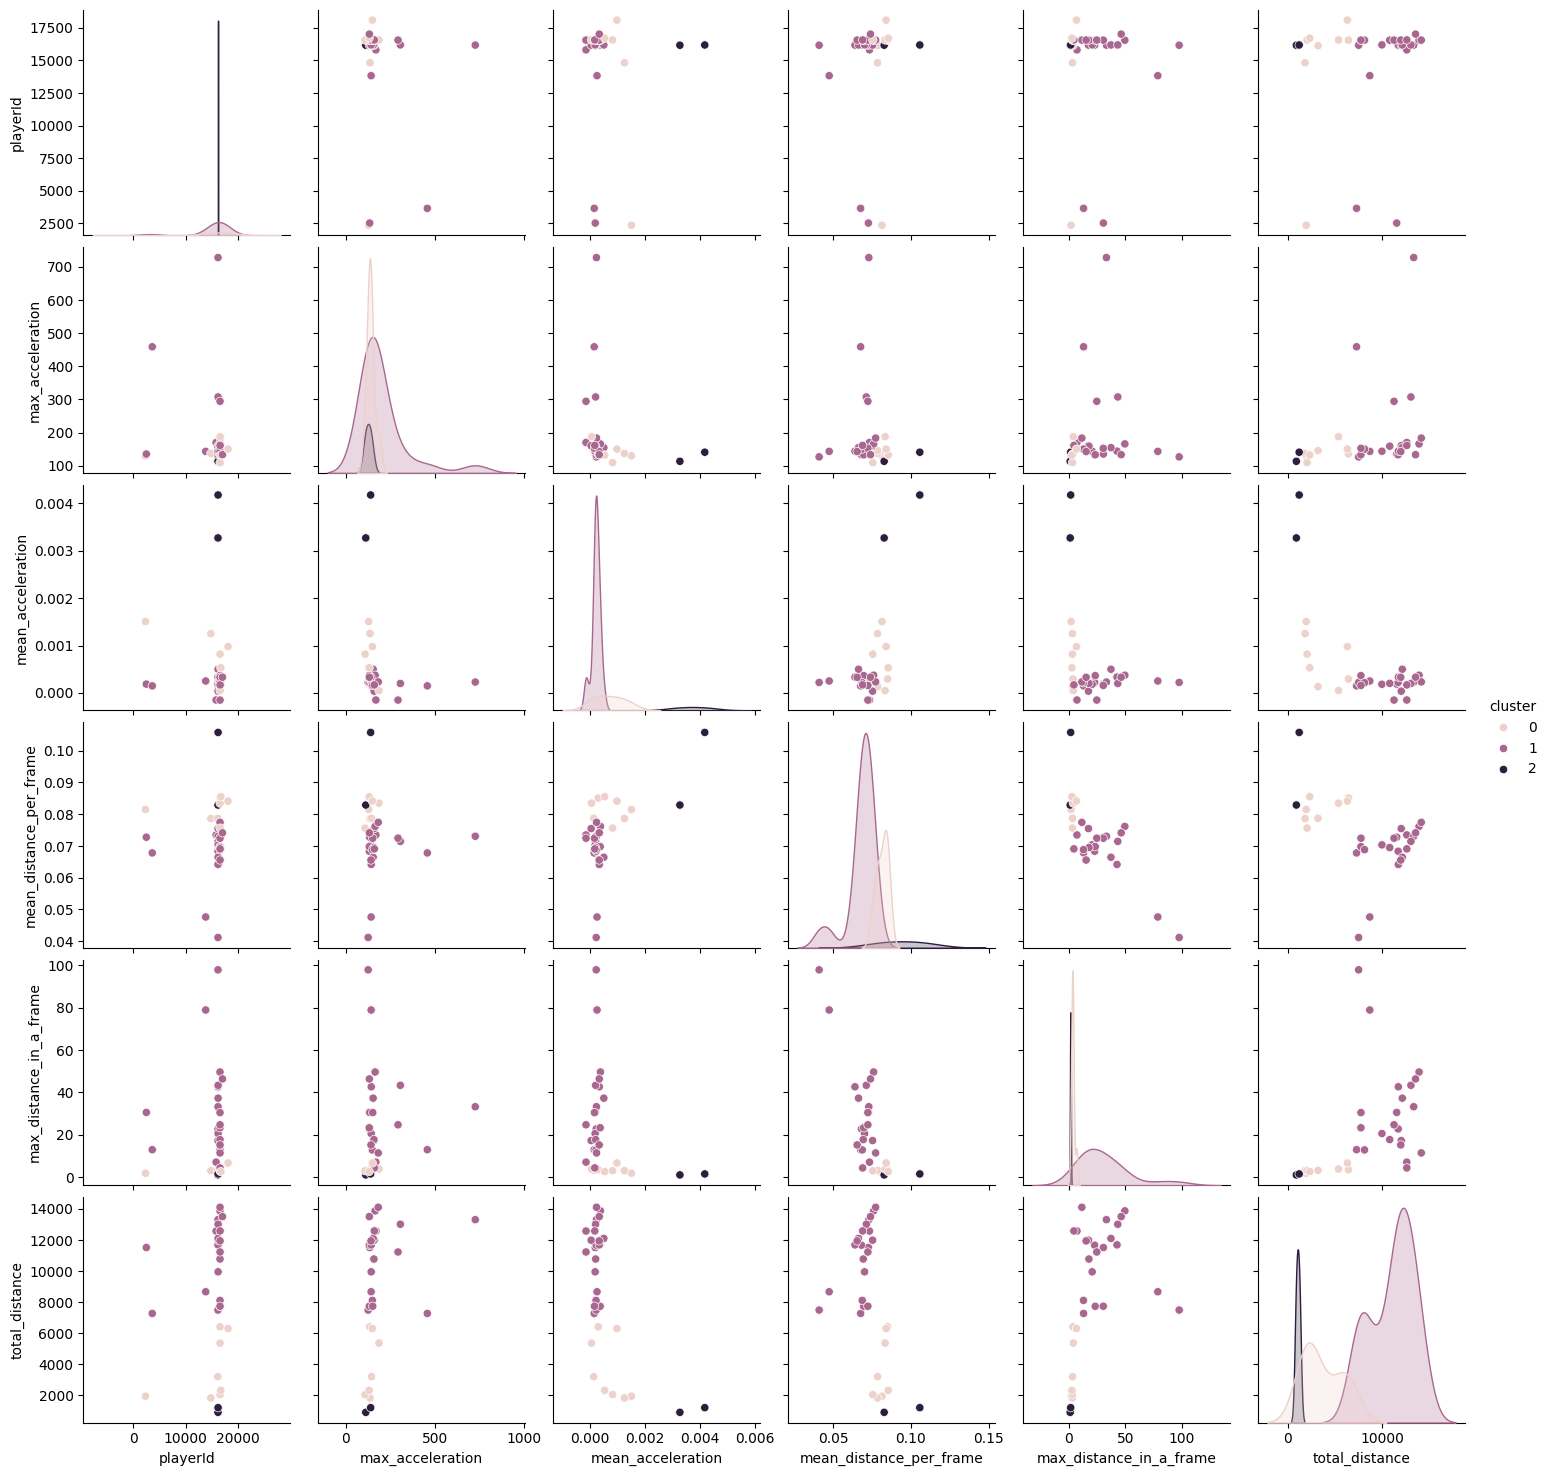

In [15]:
X = df_frames[["max_acceleration", "mean_acceleration", "mean_distance_per_frame", "max_distance_in_a_frame", "total_distance"]]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0)
df_frames["cluster"] = kmeans.fit_predict(X_scaled)

sns.pairplot(df_frames, hue="cluster", diag_kind="kde")
plt.show()

32


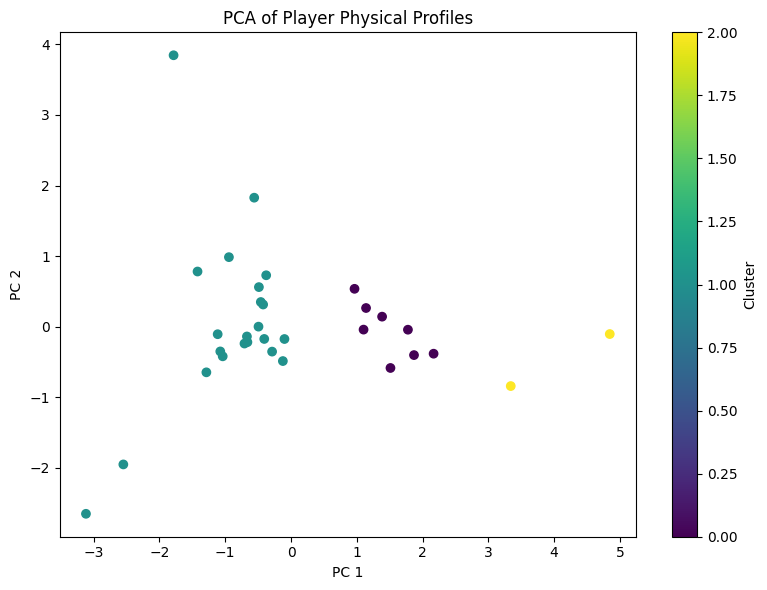

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=df_frames["cluster"], cmap="viridis")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA of Player Physical Profiles")
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df_players['id'] = df_players['id'].astype(str)
df_player_info['playerId'] = df_player_info['playerId'].astype(str)
df_frames['playerId'] = df_frames['playerId'].astype(str)

df_merged = pd.merge(
    df_players,
    df_player_info,
    left_on='id',
    right_on='playerId',
    how='inner'
)

df_merged = pd.merge(
    df_merged,
    df_frames[['playerId', 'cluster']],
    on='playerId',
    how='inner'
)

df_merged['playerName'] = df_merged['firstName'].fillna('') + ' ' + df_merged['lastName'].fillna('')
df_merged['playerName'] = df_merged['playerName'].str.strip()

df_final = df_merged[['playerId', 'playerName', 'team', 'cluster']].rename(columns={'team': 'teamName'})
df_final = df_final.drop_duplicates()

df_final

playerId                           playerName   teamName  cluster
0        2364                     Tomás Pochettino  Fortaleza        0
38       2530                       Caio Alexandre  Fortaleza        1
75       3658                         Richard Rios  Palmeiras        1
149     13829            Weverton Pereira da Silva  Palmeiras        1
184     14817                       Imanol Machuca  Fortaleza        0
205     16564                          Kaiky Naves  Palmeiras        0
238     16183                          Pedro Rocha  Fortaleza        2
248     16186             Christian Chagas Tarouco  Fortaleza        1
282     16569                            Zé Rafael  Palmeiras        1
313     16166                         João Ricardo  Fortaleza        1
346     16556                         Marcos Rocha  Palmeiras        1
374     16174                       Emanuel Brítez  Fortaleza        1
408     16551                        Gustavo Gómez  Palmeiras        1
475     16175          Guilherme de Jesus da Silva  Fortaleza        1
509     16557                     Joaquín Piquerez  Palmeiras        1
539     16167                        Lucas Crispim  Fortaleza        2
575     16552             Endrick Moreira de Sousa  Palmeiras        1
612     16172                         José Welison  Fortaleza        1
684     16550              Mayke Rocha de Oliveira  Palmeiras        1
738     16558                        Raphael Veiga  Palmeiras        1
769     18088                      Artur Guimarães  Palmeiras        0
805     16130                         Mario Santos   Flamengo        0
812     16130                         Mario Santos  Fortaleza        0
833     16549                Rony da Silva Barbosa  Palmeiras        0
863     16555                          Breno Lopes  Palmeiras        1
901     16189                        Bruno Pacheco  Fortaleza        1
936     15810             Calebe Ferreira da Silva  Fortaleza        1
966     16177                         Yago Pikachu  Fortaleza        1
1003    16560                     Murilo Cerqueira  Palmeiras        1
1030    17016  Guilherme Augusto Vieira dos Santos  Fortaleza        1
1064    16192                      Thiago Galhardo  Fortaleza        1
1097    16568           Vanderlan Barbosa da Silva  Palmeiras        0
1172    16707             Fabinho Silva de Freitas  Palmeiras        0